# imports

In [7]:
from sentence_transformers import SentenceTransformer, util
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

import sqlite3
import argparse
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
from numpy.linalg import norm
import sys
from itertools import combinations
import random

# Utils

In [21]:
class UnionFind:
    def __init__(self):
        self.parent = {}  # Dictionary to store parent nodes
        self.ranks = {}    # Dictionary to store rank (or size) of each set
        self.processed = False
        self.project_name = None

    def find(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.ranks[x] = 1
            return x

        # Path compression
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)

        if root_x != root_y:
            if self.ranks[root_x] < self.ranks[root_y]:
                self.parent[root_x] = root_y
                self.ranks[root_y] += self.ranks[root_x]
            else:
                self.parent[root_y] = root_x
                self.ranks[root_x] += self.ranks[root_y]
            
    def process_project(self, conn, project_name):
        cursor = conn.cursor()
        self.project_name = project_name
        print("Processing", project_name)
        cursor.execute(f"SELECT * FROM {project_name}")
        for row in cursor.fetchall():
            dup_id = int(row[column_names.index("dup_id")])
            if dup_id == -1: continue
            bug_id = int(row[column_names.index("bug_id")])
            assert(dup_id != bug_id)
            self.union(bug_id, dup_id)
        self.processed = True
            
    def get_roots(self,):
        assert(self.processed)
        return list(set(self.parent.values()))
    
    def get_children(self, parent):
        assert(self.processed)
        parent = self.find(parent)
        children = [key for key, value in self.parent.items() if value == parent]
        return children
    
    def get_all_children(self, ):
        return [key for key, value in self.parent.items()]
    
    def are_dups(this, bug_id1, bug_id2):
        if (bug_id1 not in this.parent.keys() or bug_id2 not in this.parent.keys()):
            return False
        return this.parent[bug_id1] == this.parent[bug_id2]
            

In [6]:
def get_bug_ids(conn, table_name):
    cursor = conn.cursor()
    column_name = "bug_id"

    # Fetch table names using SQL query
    cursor.execute(f"SELECT DISTINCT {column_name} FROM {table_name} ORDER BY {column_name};")
    distinct_values_sorted = cursor.fetchall()

    # Extract table names from the result
    return [value[0] for value in distinct_values_sorted]

In [11]:
def get_column_names(conn, table_name):
    cursor = conn.cursor()

    # Execute a query to get information about the columns in the specified table
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns_info = cursor.fetchall()

    # Extract and return the column names
    column_names = [column[1] for column in columns_info]
    return column_names

In [62]:
def get_code_feature(conn, project_name, bug_id):
    cursor = conn.cursor()

    # Fetch table names using SQL query
    query = f"SELECT * FROM {project_name} WHERE bug_id = {bug_id};"
    # print(query)
    cursor.execute(query)
    result = cursor.fetchall()[0]
    return result[column_names.index("code_feature")]

In [138]:
def get_descriptions(conn, project_name, bug_id):
    cursor = conn.cursor()

    # Fetch table names using SQL query
    query = f"SELECT * FROM {project_name} WHERE bug_id = {bug_id};"
    # print(query)
    cursor.execute(query)
    result = cursor.fetchall()[0]
    desc = result[column_names.index("description")]
    short_desc = result[column_names.index("short_desc")]

    # Extract table names from the result
    return (desc + " \n " + short_desc).replace("\\'", "'")

In [ ]:
def vectorize(description, stride_len, chunk_size):
    tokens = tokenizer.tokenize(description)
    # if len og token array is < 32, we do nothing as there is not enough information
    if (len(tokens) < chunk_size // 2): return None

    # remember to add cls and sep token at each chunk
    token_ids = tokenizer.convert_tokens_to_ids([tokenizer.cls_token]+tokens+[tokenizer.sep_token])

    # divide token ids into batche of chunks
    chunk_list=[]
    for i in range(0, len(token_ids), stride_len):
        chunk = token_ids[i:min(i+chunk_size, len(token_ids))]
        assert(len(chunk) <= chunk_size)
        if len(chunk) < chunk_size:
            # keep going
            continue
            # if (len(chunk) < chunk_size // 2): continue
            # pad_length = chunk_size - len(chunk)
            # chunk += [tokenizer.pad_token_id]*pad_length
        assert(len(chunk) == chunk_size)
        # print(chunk)
        chunk_list.append(chunk)

    if(len(chunk_list) == 0): return None
    chunk_arr = np.array(chunk_list)
    # print("Chunk arr size{}".format(chunk_arr.shape))
    # context_embedding = model(torch.tensor(token_ids[:512])[None, :])[0]
    context_embedding = model(torch.tensor(chunk_arr)[:, :])[0]
    return context_embedding.detach().numpy()

In [17]:
def get_duplicated_pairs(union_find):
    roots = union_find.get_roots()
    pairs = []
    for root in roots:
        group = union_find.get_children(root)
        pairs += list(combinations(group, 2))
    return pairs

In [53]:
def get_non_duplicated_pairs(union_find, conn, size):
    from_dup = union_find.get_all_children()
    #sample in some other single reports
    assert(union_find.processed)
    samples = random.sample(get_bug_ids(conn, union_find.project_name), len(from_dup))
    
    pairs = []
    count = 0
    while (count < size):
        pair = random.sample(samples, 2)
        if pair[0] == pair[1] or union_find.are_dups(pair[0], pair[1]):
            continue
        pairs += [(pair[0], pair[1]),]
        count += 1
    return pairs

In [129]:
def get_mislabels(union_find, bug_ids, anchor_bug_id, threshold):
    assert(threshold >= 0 and threshold <= 1)
    ret = []
    for bug_id in tqdm(bug_ids):
        if not union_find.are_dups(anchor_bug_id, bug_id):
            sim_score = get_similarity_of_pair((anchor_bug_id, bug_id),)
            if sim_score > threshold:
                ret += [bug_id]
    return ret

# Connect to the database

In [54]:
database_path = "./dbrd_w_tech_terms.db"


conn = sqlite3.connect(database_path)
cursor = conn.cursor()

# getting model

In [55]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# select eval dataset

Contains all reports in all duplicated groups, and a set of samples of single reports
From this set, we select positive (duplicated) pairs and negative (non-duplicated pairs). The set of negative pairs is 3 times larger than the duplicated pair.
We predict similarity of each selected pair of report then derives means and standard deviation of similarity scores among the positive group and negative group. We expect positive pairs have higher similarity score compared to the negative pairs.

In [56]:
project_name = "spark"

bug_ids = get_bug_ids(conn, project_name)

column_names = get_column_names(conn, project_name)

union_find = UnionFind()
union_find.process_project(conn, project_name)

In [57]:
positive_set = get_duplicated_pairs(union_find)

In [102]:
negative_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*5)

In [103]:
len(positive_set)

513

In [104]:
len(negative_set)

2565

In [170]:
def get_similarity_of_pair_with_code_feature(pair):
    sent0 = get_code_feature(conn, project_name, pair[0])
    sent1 = get_code_feature(conn, project_name, pair[1])
    sent_embedding0 = model.encode(sent0,convert_to_tensor=True)
    sent_embedding1 = model.encode(sent1,convert_to_tensor=True)
    return util.pytorch_cos_sim(sent_embedding0, sent_embedding1).numpy()[0, 0]

In [89]:
sim_scores_pos = np.array([get_similarity_of_pair_with_code_feature(pair) for pair in positive_set])

In [106]:
sim_scores_neg = np.array([get_similarity_of_pair_with_code_feature(pair) for pair in negative_set])

In [95]:
sim_scores_pos.mean()

0.55533105

In [96]:
sim_scores_pos.std()

0.19933043

In [107]:
sim_scores_neg.mean()

0.24015154

In [108]:
sim_scores_neg.std()

0.16188142

In [109]:
sim_scores_neg.max()

0.7545009

In [110]:
sim_scores_pos.max()

1.0000002

In [101]:
len(negative_set)

513

We compare with the similiarty score if the full description is used

In [159]:
def get_similarity_of_pair_with_desc(pair):
    sent0 = get_descriptions(conn, project_name, pair[0])
    sent1 = get_descriptions(conn, project_name, pair[1])
    sent_embedding0 = model.encode(sent0,convert_to_tensor=True)
    sent_embedding1 = model.encode(sent1,convert_to_tensor=True)
    return util.pytorch_cos_sim(sent_embedding0, sent_embedding1).numpy()[0, 0]

In [160]:
sim_scores_pos = np.array([get_similarity_of_pair_with_desc(pair) for pair in positive_set])

In [161]:
sim_scores_neg = np.array([get_similarity_of_pair_with_desc(pair) for pair in negative_set])

In [162]:
print(sim_scores_pos.mean(), sim_scores_pos.std())
print(sim_scores_neg.mean(), sim_scores_neg.std())

0.5849161 0.17786817
0.22830808 0.14708175


# Try on another table

In [163]:
project_name = "hadoop"

bug_ids = get_bug_ids(conn, project_name)

column_names = get_column_names(conn, project_name)

union_find = UnionFind()
union_find.process_project(conn, project_name)

In [164]:
positive_set = get_duplicated_pairs(union_find)

In [165]:
negative_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*5)

In [166]:
len(positive_set)

431

In [167]:
len(negative_set)

2155

In [171]:
sim_scores_pos = np.array([get_similarity_of_pair_with_code_feature(pair) for pair in positive_set])

In [172]:
sim_scores_neg = np.array([get_similarity_of_pair_with_code_feature(pair) for pair in negative_set])

In [173]:
print(sim_scores_pos.mean(), sim_scores_pos.std())
print(sim_scores_neg.mean(), sim_scores_neg.std())

0.57726604 0.25344652
0.15145156 0.13330194


(array([ 5.,  1.,  6.,  7.,  5.,  7.,  6.,  6., 10., 13., 19., 14., 13.,
        15., 17., 22., 12., 28., 23., 23., 14., 28., 18., 16., 28., 16.,
        16.,  7.,  8., 28.]),
 array([-0.04722407, -0.0123166 ,  0.02259088,  0.05749836,  0.09240583,
         0.12731332,  0.16222079,  0.19712827,  0.23203574,  0.26694322,
         0.30185071,  0.33675817,  0.37166566,  0.40657312,  0.44148061,
         0.4763881 ,  0.51129556,  0.54620302,  0.58111054,  0.616018  ,
         0.65092546,  0.68583292,  0.72074044,  0.7556479 ,  0.79055536,
         0.82546288,  0.86037034,  0.8952778 ,  0.93018526,  0.96509278,
         1.00000024]),
 <BarContainer object of 30 artists>)

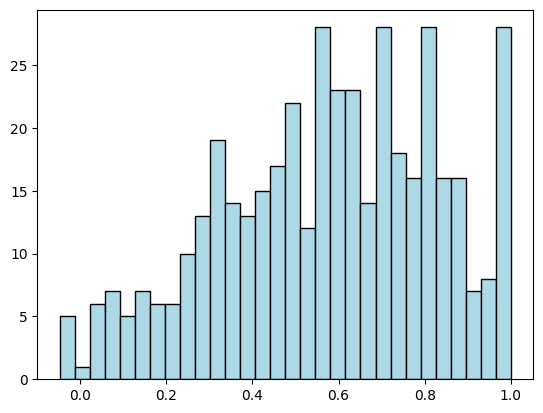

In [179]:
plt.hist(sim_scores_pos, color='lightblue', ec='black', bins=30)

(array([  4.,   6.,  31., 102., 171., 233., 284., 276., 270., 197., 142.,
        117.,  97.,  60.,  63.,  40.,  24.,  21.,  10.,   3.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.17775568, -0.13849716, -0.09923864, -0.05998012, -0.0207216 ,
         0.01853692,  0.05779544,  0.09705396,  0.13631248,  0.17557101,
         0.21482952,  0.25408804,  0.29334655,  0.33260509,  0.3718636 ,
         0.41112214,  0.45038065,  0.48963916,  0.5288977 ,  0.56815618,
         0.60741472,  0.64667326,  0.6859318 ,  0.72519028,  0.76444882,
         0.80370736,  0.84296584,  0.88222438,  0.92148292,  0.9607414 ,
         0.99999994]),
 <BarContainer object of 30 artists>)

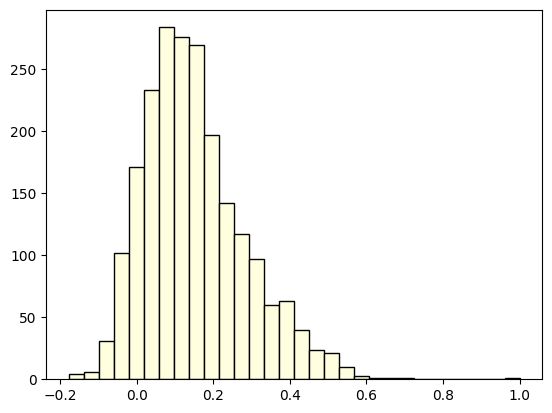

In [182]:
plt.hist(sim_scores_neg, color='lightyellow', ec='black', bins=30)

### Then compare with the similarity score if fill desc is used

In [183]:
sim_scores_pos = np.array([get_similarity_of_pair_with_desc(pair) for pair in positive_set])

In [184]:
sim_scores_neg = np.array([get_similarity_of_pair_with_desc(pair) for pair in negative_set])

In [185]:
print(sim_scores_pos.mean(), sim_scores_pos.std())
print(sim_scores_neg.mean(), sim_scores_neg.std())

0.6101277 0.21461695
0.17452173 0.12698874


(array([ 1.,  1.,  0.,  1.,  3.,  3.,  6.,  7.,  8.,  8., 10., 12., 15.,
        14., 18., 28., 26., 23., 29., 34., 24., 20., 28., 25., 18., 14.,
        16.,  5.,  8., 26.]),
 array([-0.04871121, -0.01375417,  0.02120288,  0.05615992,  0.09111696,
         0.12607402,  0.16103105,  0.1959881 ,  0.23094514,  0.26590219,
         0.30085924,  0.33581626,  0.37077332,  0.40573037,  0.44068742,
         0.47564447,  0.51060152,  0.54555857,  0.58051556,  0.61547261,
         0.65042967,  0.68538672,  0.72034377,  0.75530082,  0.79025787,
         0.82521492,  0.86017191,  0.89512897,  0.93008602,  0.96504307,
         1.00000012]),
 <BarContainer object of 30 artists>)

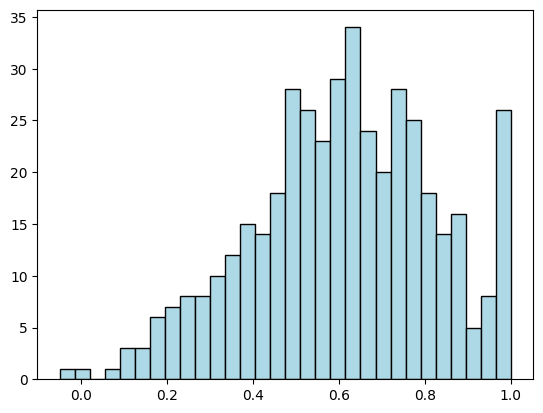

In [186]:
plt.hist(sim_scores_pos, color='lightblue', ec='black', bins=30)

(array([  5.,  12.,  27.,  30.,  68., 107., 138., 182., 174., 200., 185.,
        176., 159., 139., 116.,  82.,  80.,  66.,  55.,  54.,  19.,  31.,
         19.,  11.,  11.,   3.,   2.,   1.,   1.,   2.]),
 array([-0.12909278, -0.10215863, -0.07522447, -0.04829032, -0.02135616,
         0.005578  ,  0.03251215,  0.05944631,  0.08638047,  0.11331462,
         0.14024878,  0.16718294,  0.19411708,  0.22105125,  0.24798539,
         0.27491957,  0.30185372,  0.32878786,  0.35572201,  0.38265619,
         0.40959033,  0.43652448,  0.46345866,  0.4903928 ,  0.51732695,
         0.5442611 ,  0.57119524,  0.59812945,  0.6250636 ,  0.65199775,
         0.67893189]),
 <BarContainer object of 30 artists>)

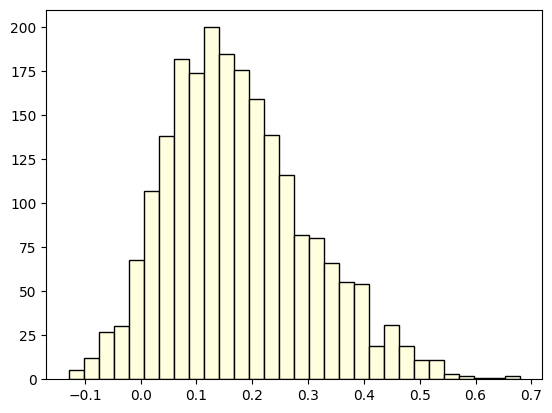

In [187]:
plt.hist(sim_scores_neg, color='lightyellow', ec='black', bins=30)